In [23]:
rm(list = ls())
options(warn=-1)
options(repr.matrix.max.rows=30, repr.matrix.max.cols=200)
packages = list("dplyr","ROCR","glmnet","ggplot2",
            "pROC","SDMTools","purrr")
invisible(sapply(packages,library,character.only = TRUE))

In [24]:
cur_dir = '/home/jacob/Projects/PE_project'
data_dir = file.path(cur_dir, 'data')

In [25]:
setwd(data_dir)
data_NUS = readxl::read_excel("Book1.xlsx") %>%
           purrr::map(as.numeric) %>% as.data.frame

### Extract required fields 
data_NUS =          sqldf::sqldf("select
                      
                      [Age_raw] as Age,
                      [PESI.Gender..Male.sex...10..Female...0.] as [Gender],
                      [PESI.Cancer..Active.CA..60.] as [Cancer_active],
                      [PESI.CCF..Heart.failure..10.] as [Heart_failure],
                      [PESI.CLD..Chronic.lung.disease..10.] as [Lung_disease],
                      [PESI.HR...110..20.] as [HR>110],
                      [PESI.BP...100..30.] as [BP>100],
                      [PESI.RR...30..20.] as [RR>30],
                      [Temp...C.] as [Temp],
                      [PESI.AMS..60] as [AMS],
                      [PESI.SpO2.90..20] as [SaO2<90],
                      [IV_required..0.N..1.Y.] as [IV_required],
                      [tPA.contraindicated..0.No..1.Yes.] as [tPA],
                      [eGFR] as eGFR,
                      [Bilirubin] as [Bilirubin],
                      [BMI] as [BMI],
                      [ALT],
                      [AST],
                      [Immobile..0.N..1.Y.] as [Immobile],
                      [Haemoptysis..0.N..1.Y.] as [Hemoptysis],
                      [Troponin.I...0.039.is.abnormal.] as [Troponin],
                      [Symptoms.of.DVT..0.N..1.Y.] as [DVT],
                      [Previous.VTE..0.N..1.Y.] as [VTE],
                      [Anticoagulated.Prior.to.Dx..0.N.or.non.compliant..1.Y.] as [Anticoagulated_history],
                      [NT.proBNP...194.] as [BNP],
                      [CTVS.Ref.First..0.N..1.Y.] as [CTVS],
                      (case when [X30.day.mortality..0.dead..1.alive.] = 1 then 0
                      else 1 end) as [Mortality]

                      from data_NUS"
                       )


### Extract fields used in PESI risk stratification model and 
### Calculate each individual's PESI score by summing up the 
### patients age in years and the scores for each characteristic present.
data_NUS_PESI =  data.frame(cbind(rowSums(
                 subset(data_NUS, select = c(Age, 
                                             Gender,
                                             Cancer_active,
                                             Heart_failure,
                                             Lung_disease,
                                             `HR>110`,
                                             `BP>100`,
                                             `RR>30`, 
                                             `AMS`,
                                             `SaO2<90`)),
                                  ifelse(data_NUS$Temp < 36 , 20 , 0 )),
                                  data_NUS$Mortality))
colnames(data_NUS_PESI) = c('PESI_score','Mortality')



### Convert PESI predictors with assigned score into binary. 
data_NUS[c('Gender','Cancer_active', 'Heart_failure', 'Lung_disease','HR>110','BP>100','RR>30','AMS','SaO2<90')] = 
ifelse(data_NUS[c('Gender','Cancer_active', 'Heart_failure', 'Lung_disease','HR>110','BP>100','RR>30','AMS','SaO2<90')]!=0 , 1,0)

### impute some of required fields with missing values using KNN imputation
data_NUS =  DMwR::knnImputation(data_NUS, k = 3, scale = T, meth = "weighAvg")

### filterout fileds which does not show strong correlation to Mortality.  
data_NUS_NEW = subset(data_NUS , select = -c(Temp,
                                             Gender,
                                            BNP,
                                            BMI,
                                            CTVS,
                                            AST,
                                            Bilirubin,
                                           `HR>110`,
                                           `SaO2<90`,
                                            VTE,
                                            Immobile,
                                           `BP>100`,
                                            eGFR,
                                            tPA,
                                           Troponin,
                                           Anticoagulated_history,
                                           Cancer_active,
                                           DVT
                                            ))

## After impuation, in order to synchronize with other predictors, 
## ALT was also converted to binary form. Its threshold was set to 75. 
data_NUS_NEW$ALT = ifelse(data_NUS_NEW$ALT > 75, 1 , 0 )

9 x 1 sparse Matrix of class "dgCMatrix"
                 1
(Intercept)   -112
Age              1
Heart_failure   18
Lung_disease    24
RR>30           37
AMS             12
IV_required     49
ALT             43
Hemoptysis      62
auc_NEW =  0.7930233
auc_PESI =  0.6511628
Threshold =  95.17902

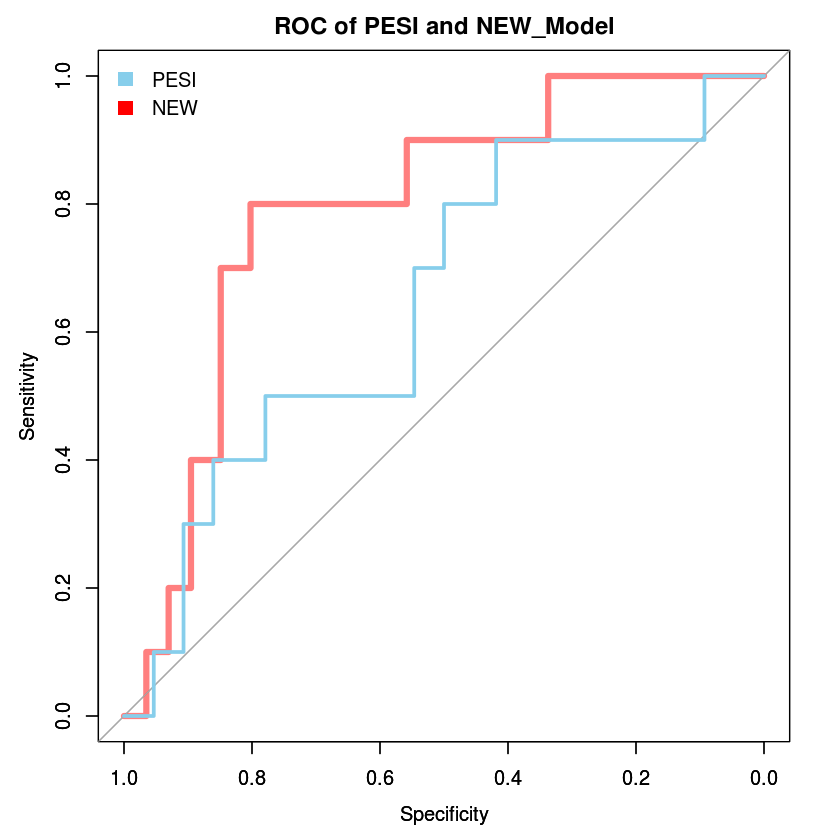

In [26]:
### Set Seed
set.seed(187)

### Split Test and Train Data
### - Split_Ratio = 0.7
### - oversample positive case in trainset to match its size 
###   with negative case 

splitIndex = caTools::sample.split(data_NUS$Mortality, SplitRatio = 0.7)
Index_test = which(splitIndex == FALSE)


Index_train = append(
                    
                     sample(which(data_NUS$Mortality == 1 & splitIndex == TRUE) , 
                     length(which(data_NUS$Mortality == 0 & splitIndex == TRUE)),
                     replace = TRUE)
                    ,
                      sample(which(data_NUS$Mortality == 0 & splitIndex == TRUE), 
                     length(which(data_NUS$Mortality == 0 & splitIndex == TRUE)),
                     replace = FALSE)
                     )
    
                                  
### Train a model 
### - model: Elastic logistic regression
### - lowerlimit of coefficiants : 0
### - alhpha: 0.5
### - family = "binomial"
        
lower = c(-Inf,rep(0,ncol(data_NUS_NEW) -1 ))

mle = cv.glmnet(as.matrix(subset(data_NUS_NEW[Index_train,], select = -c(Mortality))),
            data_NUS_NEW$Mortality[Index_train],
            alpha = 0.5,
            intercept=T,
            family="binomial")

### get coefficients
new_coef = coef(mle,s = "lambda.min")
### get weights 
new_score = coef(mle,s = "lambda.min") / coef(mle,s = "lambda.min")[2]
### print weights
print(round(coef(mle,s = "lambda.min")/coef(mle,s = "lambda.min")[2],0))

temp = as.matrix(subset(data_NUS_NEW, select = -c(Mortality))) %*% as.matrix(new_score[-1])
saveRDS(temp , "new_score3.Rda")

pred_new =  pracma::sigmoid( 
               cbind(1,as.matrix(subset(data_NUS_NEW[Index_test,], select = -c(Mortality))))
               %*%
               matrix(new_coef)
                  )

roc_NEW = roc(data_NUS_NEW$Mortality[Index_test], pred_new , ci = TRUE)
auc_NEW = auc(data_NUS_NEW$Mortality[Index_test], pred_new)
cat("auc_NEW = ",auc_NEW)
cat('\n')


## Get AUC of PESI model
roc_PESI = roc(data_NUS_PESI$Mortality[Index_test], data_NUS_PESI$PESI_score[Index_test], ci = TRUE)
auc_PESI = auc(data_NUS_PESI$Mortality[Index_test], data_NUS_PESI$PESI_score[Index_test])
cat("auc_PESI = ", auc_PESI)
cat('\n')


### New Model Validation

## Save Score for each patient into a file.
out = as.matrix(subset(data_NUS_NEW, select = -c(Mortality))) %*% as.matrix(new_score[-1])
saveRDS(out , "new_score3.Rda")


## AUC comparison of new_model and PESI model.

plot(roc_NEW, col=scales::alpha('red',.5),lwd = 5 , main= 'ROC of PESI and NEW_Model')
par(new=TRUE)
plot(roc_PESI, col='skyblue',lwd = 3) 
legend('topleft',c('PESI','NEW'),
       fill = c("skyblue","red"), bty = 'n',
       border = NA)


out =  as.matrix(subset(data_NUS_NEW[Index_train,], select = -c(Mortality))) %*% 
           new_score[-1]
cut_Off =optim.thresh(data_NUS_NEW$Mortality[Index_train],out/max(out))
cut_Off = cut_Off$`max.sensitivity+specificity`
cat("Threshold = ",cut_Off * max(out))